# $\color{Green}{\text{Fundamentals of Inference and Learning}}$ 
Name: Roduit \
Surname : Vincent \
Sciper: 325140
## Homework 2
### Exercise 1 : Classifying digits with Scikit-learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 1) Import and prepare datas

In [2]:
#Load datas
from sklearn.datasets import load_digits
x,y = load_digits(return_X_y=True)

In [3]:
# Change the output to 0 if even and 1 if odd
y = [0 if i % 2 == 0 else 1 for i in y]

In [4]:
#split into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=1)

In [5]:
#Check proportion of 1 in train and test
prop1_train = np.sum(y_train)/len(y_train)
prop1_test = np.sum(y_test)/len(y_test)
print(f'The proportion of 1 in the train set is {prop1_train*100:.2f}%')
print(f'The proportion of 1 in the test set is {prop1_test*100:.2f}%')

The proportion of 1 in the train set is 50.26%
The proportion of 1 in the test set is 50.89%


### 2) Logistic Regression

In [6]:
def accuracy(y_pred, y_test):
    return np.sum(y_pred == y_test)/len(y_test)
def f1_score(y_pred, y_test):
    tp = np.sum((y_pred == 1) & (y_test == 1))
    fp = np.sum((y_pred == 1) & (y_test == 0))
    fn = np.sum((y_pred == 0) & (y_test == 1))
    return 2*tp/(2*tp + fp + fn)

### Cross validation to fix hyperparamters
1) Case with $\mathscr{l}_1$ penalty

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

In [8]:
# perform a grid search to find the best parameter lambda

# Create a pipeline with logistic regression and scaling
pipe_l1 = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', solver='liblinear'))

# define the cross-validation method
cv = ShuffleSplit(n_splits=5, test_size=0.05, random_state=1)

# define the parameter grid
param_grid = [
    {'logisticregression__C': 1 / np.logspace(-1, 4, 20)}  #'C' is the inverse of lambda
]

cv_logreg_l1 = GridSearchCV(pipe_l1, param_grid, cv=cv, scoring='accuracy', return_train_score=True)
cv_logreg_l1.fit(x_train, y_train)



GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=1, test_size=0.05, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(penalty='l1',
                                                           solver='liblinear'))]),
             param_grid=[{'logisticregression__C': array([1.00000000e+01, 5.45559478e+00, 2.97635144e+00, 1.62377674e+00,
       8.85866790e-01, 4.83293024e-01, 2.63665090e-01, 1.43844989e-01,
       7.84759970e-02, 4.28133240e-02, 2.33572147e-02, 1.27427499e-02,
       6.95192796e-03, 3.79269019e-03, 2.06913808e-03, 1.12883789e-03,
       6.15848211e-04, 3.35981829e-04, 1.83298071e-04, 1.00000000e-04])}],
             return_train_score=True, scoring='accuracy')

In [9]:
cvOptLambda_l1 = 1 / cv_logreg_l1.best_params_['logisticregression__C']
print(f'In this case, the optimal lambda is {cvOptLambda_l1:.2f}')

In this case, the optimal lambda is 2.07


Let's visualize the result !

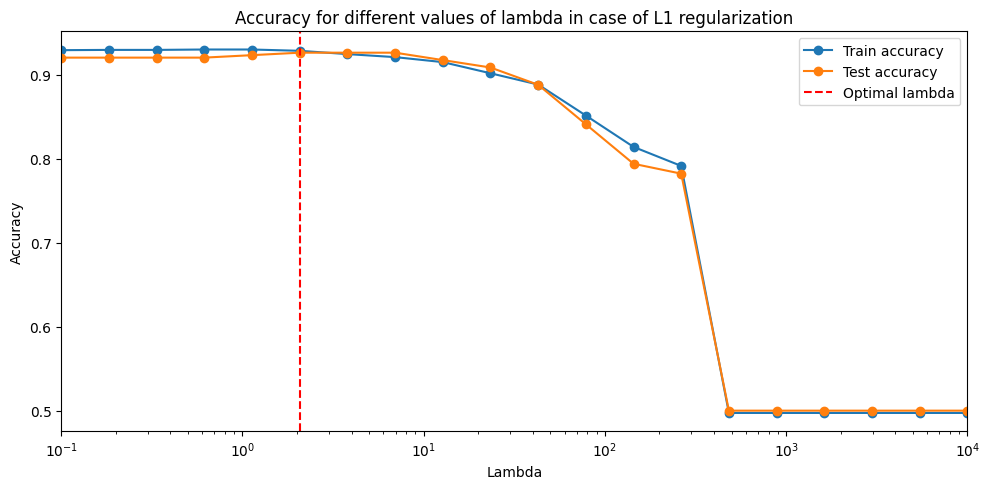

In [10]:
testedLambdas = 1 / cv_logreg_l1.cv_results_['param_logisticregression__C'].data
trainAcc = cv_logreg_l1.cv_results_['mean_train_score']
testAcc = cv_logreg_l1.cv_results_['mean_test_score']

plt.figure(figsize=(10, 5))
plt.plot(testedLambdas, trainAcc, 'o-', label='Train accuracy')
plt.plot(testedLambdas, testAcc, 'o-', label='Test accuracy')
plt.axvline(cvOptLambda_l1, color='r', linestyle='--', label='Optimal lambda')

plt.title('Accuracy for different values of lambda in case of L1 regularization')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')

plt.semilogx()
plt.xlim([testedLambdas[0], testedLambdas[-1]])

plt.tight_layout()
plt.legend()
plt.show()

1) Case with $\mathscr{l}_2$ penalty

In [11]:
# perform a grid search to find the best parameter lambda

# Create a pipeline with logistic regression and scaling
pipe_l2 = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', solver='liblinear'))

# define the cross-validation method
cv = ShuffleSplit(n_splits=5, test_size=0.05, random_state=1)

# define the parameter grid
param_grid = [
    {'logisticregression__C': 1 / np.logspace(-1, 4, 20)}  #'C' is the inverse of lambda
]

cv_logreg_l2 = GridSearchCV(pipe_l2, param_grid, cv=cv, scoring='accuracy', return_train_score=True)
cv_logreg_l2.fit(x_train, y_train)


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=1, test_size=0.05, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid=[{'logisticregression__C': array([1.00000000e+01, 5.45559478e+00, 2.97635144e+00, 1.62377674e+00,
       8.85866790e-01, 4.83293024e-01, 2.63665090e-01, 1.43844989e-01,
       7.84759970e-02, 4.28133240e-02, 2.33572147e-02, 1.27427499e-02,
       6.95192796e-03, 3.79269019e-03, 2.06913808e-03, 1.12883789e-03,
       6.15848211e-04, 3.35981829e-04, 1.83298071e-04, 1.00000000e-04])}],
             return_train_score=True, scoring='accuracy')

In [12]:
cvOptLambda_l2 = 1 / cv_logreg_l2.best_params_['logisticregression__C']
print(f'In this case, the optimal lambda is {cvOptLambda_l2:.2f}')

In this case, the optimal lambda is 23.36


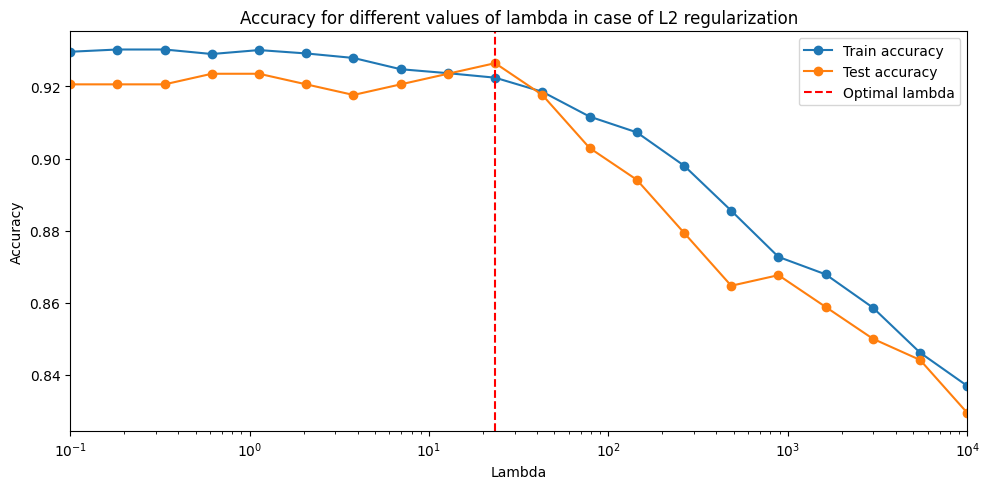

In [13]:
testedLambdas = 1 / cv_logreg_l2.cv_results_['param_logisticregression__C'].data
trainAcc = cv_logreg_l2.cv_results_['mean_train_score']
testAcc = cv_logreg_l2.cv_results_['mean_test_score']

plt.figure(figsize=(10, 5))
plt.plot(testedLambdas, trainAcc, 'o-', label='Train accuracy')
plt.plot(testedLambdas, testAcc, 'o-', label='Test accuracy')
plt.axvline(cvOptLambda_l2, color='r', linestyle='--', label='Optimal lambda')

plt.title('Accuracy for different values of lambda in case of L2 regularization')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')

plt.semilogx()
plt.xlim([testedLambdas[0], testedLambdas[-1]])

plt.tight_layout()
plt.legend()
plt.show()

Now let's find the prediction and the corresponding accuracy for the test set for the two logistic regressions:

In [14]:
# Set the optimal lambda to the model
pipe_l1.set_params(logisticregression__C=cvOptLambda_l1)
pipe_l2.set_params(logisticregression__C=cvOptLambda_l2)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=23.357214690901213, solver='liblinear'))])

In [15]:
#compute the predictions
y_pred_l1 = cv_logreg_l1.predict(x_test)
y_pred_l2 = cv_logreg_l2.predict(x_test)

#Compute the accuracies
acc_pred_l1 = accuracy(y_pred_l1, y_test)
acc_pred_l2 = accuracy(y_pred_l2, y_test)  

In [16]:
print(f'For the L1 regularization, the accuracy on the test set is {acc_pred_l1*100:.2f}%')
print(f'For the L2 regularization, the accuracy on the test set is {acc_pred_l2*100:.2f}%')

For the L1 regularization, the accuracy on the test set is 92.89%
For the L2 regularization, the accuracy on the test set is 93.11%


3) Ridge and Hinge \
a) Ridge

In [17]:
from sklearn.linear_model import RidgeClassifier

In [18]:
# Create a pipeline with Ridge regression and scaling
pipe_ridge = make_pipeline(StandardScaler(), RidgeClassifier())

# define the cross-validation method
cv = ShuffleSplit(n_splits=5, test_size=0.05, random_state=1)

# define the parameter grid
param_grid = [
    {'ridgeclassifier__alpha': np.logspace(1, 7, 20)/2} # alpha = 1/2C = lambda/2
]

cv_ridge = GridSearchCV(pipe_ridge, param_grid, cv=cv, scoring='accuracy', return_train_score=True)
cv_ridge.fit(x_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=1, test_size=0.05, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridgeclassifier', RidgeClassifier())]),
             param_grid=[{'ridgeclassifier__alpha': array([5.00000000e+00, 1.03456904e+01, 2.14066620e+01, 4.42933395e+01,
       9.16490355e+01, 1.89634510e+02, 3.92379985e+02, 8.11888370e+02,
       1.67990914e+03, 3.47596398e+03, 7.19224944e+03, 1.48817572e+04,
       3.07924106e+04, 6.37137493e+04, 1.31832545e+05, 2.72779739e+05,
       5.64418946e+05, 1.16786073e+06, 2.41646512e+06, 5.00000000e+06])}],
             return_train_score=True, scoring='accuracy')

In [19]:
cvOptLambda_ridge = 2 *cv_ridge.best_params_['ridgeclassifier__alpha']
print(f'In this case, the optimal lambda is {cvOptLambda_ridge:.2f}')

In this case, the optimal lambda is 379.27


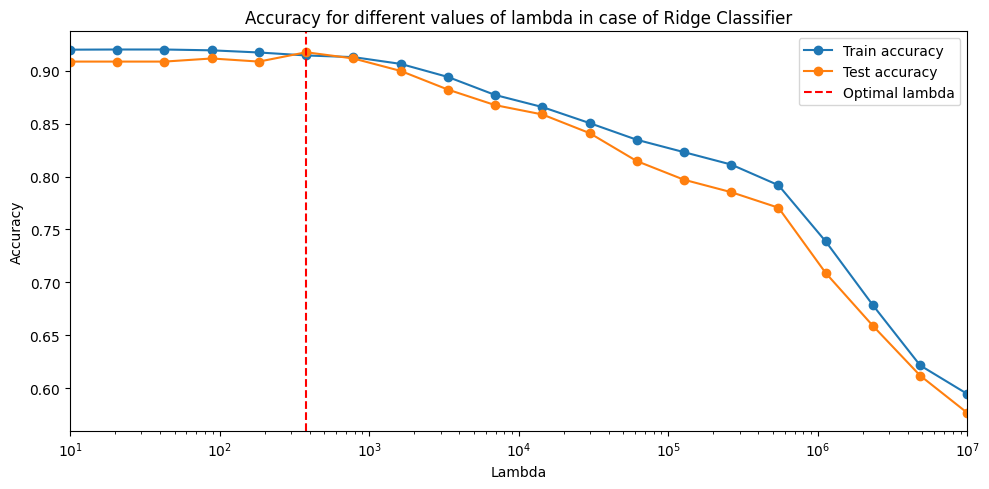

In [20]:
testedLambdas = 2 * cv_ridge.cv_results_['param_ridgeclassifier__alpha'].data
trainAcc = cv_ridge.cv_results_['mean_train_score']
testAcc = cv_ridge.cv_results_['mean_test_score']

plt.figure(figsize=(10, 5))
plt.plot(testedLambdas, trainAcc, 'o-', label='Train accuracy')
plt.plot(testedLambdas, testAcc, 'o-', label='Test accuracy')
plt.axvline(cvOptLambda_ridge, color='r', linestyle='--', label='Optimal lambda')

plt.title('Accuracy for different values of lambda in case of Ridge Classifier')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')

plt.semilogx()
plt.xlim([testedLambdas[0], testedLambdas[-1]])

plt.tight_layout()
plt.legend()
plt.show()

b) Hinge

In [21]:
from sklearn.svm import LinearSVC

In [22]:
# Create a pipeline with LinearSVC and scaling
pipe_hinge = make_pipeline(StandardScaler(), LinearSVC(loss='hinge', max_iter=100000))

# define the cross-validation method
cv = ShuffleSplit(n_splits=5, test_size=0.05)

# define the parameter grid
param_grid = [
    {'linearsvc__C': 1 /np.logspace(0, 4, 20)}
]

cv_hinge = GridSearchCV(pipe_hinge, param_grid, cv=cv, scoring='accuracy', return_train_score=True)
cv_hinge.fit(x_train, y_train)


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.05, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearsvc',
                                        LinearSVC(loss='hinge',
                                                  max_iter=100000))]),
             param_grid=[{'linearsvc__C': array([1.00000000e+00, 6.15848211e-01, 3.79269019e-01, 2.33572147e-01,
       1.43844989e-01, 8.85866790e-02, 5.45559478e-02, 3.35981829e-02,
       2.06913808e-02, 1.27427499e-02, 7.84759970e-03, 4.83293024e-03,
       2.97635144e-03, 1.83298071e-03, 1.12883789e-03, 6.95192796e-04,
       4.28133240e-04, 2.63665090e-04, 1.62377674e-04, 1.00000000e-04])}],
             return_train_score=True, scoring='accuracy')

In [23]:
cvOptLambda_hinge = 1 / cv_hinge.best_params_['linearsvc__C']
print(f'In this case, the optimal lambda is {cvOptLambda_hinge:.2f}')

In this case, the optimal lambda is 48.33


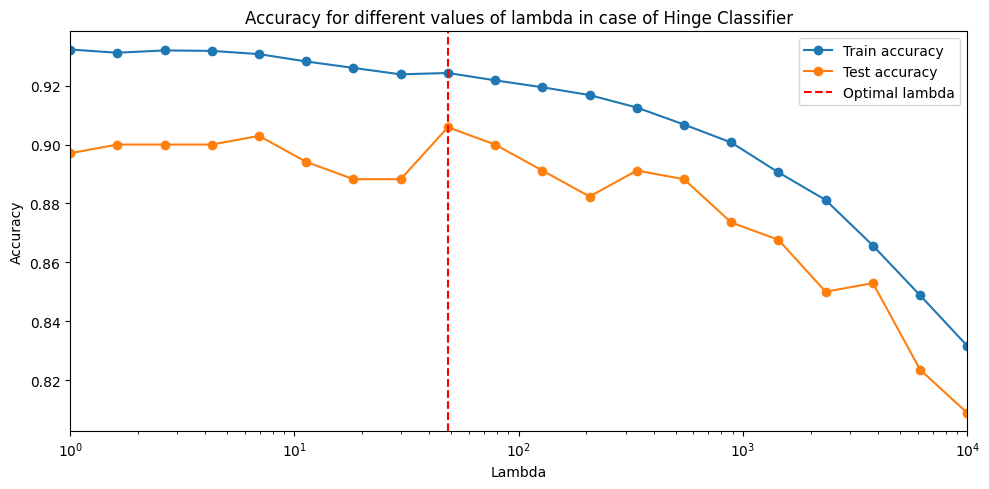

In [24]:
testedLambdas = 1 / cv_hinge.cv_results_['param_linearsvc__C'].data
trainAcc = cv_hinge.cv_results_['mean_train_score']
testAcc = cv_hinge.cv_results_['mean_test_score']

plt.figure(figsize=(10, 5))
plt.plot(testedLambdas, trainAcc, 'o-', label='Train accuracy')
plt.plot(testedLambdas, testAcc, 'o-', label='Test accuracy')
plt.axvline(cvOptLambda_hinge, color='r', linestyle='--', label='Optimal lambda')

plt.title('Accuracy for different values of lambda in case of Hinge Classifier')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')

plt.semilogx()
plt.xlim([testedLambdas[0], testedLambdas[-1]])

plt.tight_layout()
plt.legend()
plt.show()

In [25]:
#compute the predictions
y_pred_ridge = cv_ridge.predict(x_test)
y_pred_hinge = cv_hinge.predict(x_test)

#Compute the accuracies
y_pred_ridge = accuracy(y_pred_ridge, y_test)
y_pred_hinge = accuracy(y_pred_hinge, y_test)  

In [26]:
print(f'For the L1 regularization, the accuracy on the test set is {acc_pred_l1*100:.2f}%')
print(f'For the L2 regularization, the accuracy on the test set is {acc_pred_l2*100:.2f}%')

For the L1 regularization, the accuracy on the test set is 92.89%
For the L2 regularization, the accuracy on the test set is 93.11%


4. Random Forest

In [ ]:
# Create a pipeline with LinearSVC and scaling
from sklearn.ensemble import RandomForestClassifier

pipe_random_forest = make_pipeline(StandardScaler(), RandomForestClassifier())

# define the cross-validation method
cv = ShuffleSplit(n_splits=5, test_size=0.05)

# define the parameter grid
param_grid = [
    {'linearsvc__C': 1 /np.logspace(0, 4, 20)}
]

cv_hinge = GridSearchCV(pipe_hinge, param_grid, cv=cv, scoring='accuracy', return_train_score=True)
cv_hinge.fit(x_train, y_train)
